<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/PINN_DiscreteTimeFormulation_Perdikaris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# USNCCM15 Short Course

# SC15-009: Recent Advances in Physics-Informed Deep Learning

# Hands-on tutorial on Physics-Informed Neural Networks 
## (Part II: Discrete time formulation)
## Instructor: Paris Perdikaris, pgp@seas.upenn.edu
## Code repository: https://github.com/PredictiveIntelligenceLab/USNCCM15-Short-Course-Recent-Advances-in-Physics-Informed-Deep-Learning

# Physics-informed neural networks in discrete time

One potential limitation of the continuous time neural network models (see [Part I](https://github.com/PredictiveIntelligenceLab/USNCCM15-Short-Course-Recent-Advances-in-Physics-Informed-Deep-Learning) of this tutorial) considered so far stems from the need to use a large number of collocation points $N_r$ in order to enforce physics-informed constraints in the entire spatio-temporal domain. Although this poses no significant issues for problems in one or two spatial dimensions, it may introduce a severe bottleneck in higher dimensional problems, as the total number of collocation points needed to globally enforce a physics-informed constrain (i.e., in our case a partial differential equation) will increase exponentially. Although this limitation could be addressed to some extend using sparse grid or quasi Monte-Carlo sampling schemes \cite{bungartz2004sparse,sloan1998quasi}, in the next section, we put forth a different approach that circumvents the need for collocation points by introducing a more structured neural network representation leveraging the classical Runge-Kutta time-stepping schemes \cite{iserles2009first}.

## Model specification
To provide an overview of the formualtion, let us apply the general form of Runge-Kutta methods with $q$ stages \cite{iserles2009first} to a general PDE equation and obtain

$$
\begin{array}{ll}
u^{n+c_i} = u^n - \Delta t \sum_{j=1}^q a_{ij} \mathcal{N}[u^{n+c_j}], \ \ i=1,\ldots,q,\\
u^{n+1} = u^{n} - \Delta t \sum_{j=1}^q b_j \mathcal{N}[u^{n+c_j}].
\end{array}
$$

Here, $u^{n+c_j}(x) = u(t^n + c_j \Delta t, x)$ for $j=1, \ldots, q$. This general form encapsulates both implicit and explicit time-stepping schemes, depending on the choice of the parameters $\{a_{ij},b_j,c_j\}$. The above equations  can be equivalently expressed as

$$
\begin{array}{ll}
u^{n} = u^n_i, \ \ i=1,\ldots,q,\\
u^n = u^n_{q+1},
\end{array}
$$

where

$$
\begin{array}{ll}
u^n_i := u^{n+c_i} + \Delta t \sum_{j=1}^q a_{ij} \mathcal{N}[u^{n+c_j}], \ \ i=1,\ldots,q,\\
u^n_{q+1} := u^{n+1} + \Delta t \sum_{j=1}^q b_j \mathcal{N}[u^{n+c_j}].
\end{array}
$$

We now proceed by placing a multi-output neural network prior on
$$
\begin{bmatrix}
u^{n+c_1}(x), \ldots, u^{n+c_q}(x), u^{n+1}(x)
\end{bmatrix}.
$$
This prior assumption results in a \emph{physics-informed neural network} (PINN) that takes $x$ as an input and outputs
$$
\begin{bmatrix}
u^n_1(x), \ldots, u^n_q(x), u^n_{q+1}(x)
\end{bmatrix}.
$$

## Model training

To illustrate the training procedure of a discrete-time PINN, let us consider the Allen-Cahn equation with periodic boundary conditions
\begin{eqnarray} \label{eq:Allen-Cahn}
&&u_t - 0.0001 u_{xx} + 5 u^3 - 5 u = 0, \ \ \ x \in [-1,1], \ \ \ t \in [0,1],\\
&&u(0, x) = x^2 \cos(\pi x),\nonumber\\
&&u(t,-1) = u(t,1),\nonumber\\
&&u_x(t,-1) = u_x(t,1).\nonumber
\end{eqnarray}

The Allen-Cahn equation is a well-known equation from the area of reaction-diffusion systems. It describes the process of phase separation in multi-component alloy systems, including order-disorder transitions. For the Allen-Cahn equation, the nonlinear operator is given by
$$
\mathcal{N}[u^{n+c_j}] = -0.0001 u^{n+c_j}_{xx} + 5 \left(u^{n+c_j}\right)^3 - 5 u^{n+c_j},
$$
and the shared parameters of the neural networks can be learned by minimizing the sum of squared errors
\begin{equation}
SSE = SSE_n + SSE_b,
\end{equation}
where
$$
SSE_n = \sum_{j=1}^{q+1} \sum_{i=1}^{N_n} |u^n_j(x^{n,i}) - u^{n,i}|^2,
$$
and
\begin{eqnarray*}
SSE_b &=& \sum_{i=1}^q |u^{n+c_i}(-1) - u^{n+c_i}(1)|^2 + |u^{n+1}(-1) - u^{n+1}(1)|^2 \\
      &+& \sum_{i=1}^q |u_x^{n+c_i}(-1) - u_x^{n+c_i}(1)|^2 + |u_x^{n+1}(-1) - u_x^{n+1}(1)|^2.
\end{eqnarray*}
Here, $\{x^{n,i}, u^{n,i}\}_{i=1}^{N_n}$ corresponds to the data at time-step $t^n$. In classical numerical analysis, these time-steps are usually confined to be small due to stability constraints for explicit schemes or computational complexity constrains for implicit formulations \cite{iserles2009first}. These constraints become more severe as the total number of Runge-Kutta stages $q$ is increased, and, for most problems of practical interest, one needs to take thousands to millions of such steps until the solution is resolved up to a desired final time. In sharp contrast to classical methods, here we can employ implicit Runge-Kutta schemes with an arbitrarily large number of stages at effectively very little extra cost.To be precise, it is only the number of parameters in the last layer of the neural network that increases linearly with the total number of stages.} This enables us to take very large time steps while retaining stability and high predictive accuracy, therefore allowing us to resolve the entire spatio-temporal solution in a single step.

# Tensorflow Implementation
All elements defining our discrete-time neural network implementation can be summarized in the following Tensorflow class.

In [ ]:
# Import required packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import scipy.io
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fix random seed for reproducibility
np.random.seed(1234)
tf.set_random_seed(1234)

/Users/paris/tensorflow/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [ ]:
class AllenCahn1D:
    # Initialize the class
    def __init__(self, x0, u0, x1, layers, dt, q):
        
        # Normalization constants
        self.mu_x, self.sigma_x = x0.mean(0), x0.std(0)
        
        # Normalize inputs
        x0 = (x0 - self.mu_x)/self.sigma_x
        x1 = (x1 - self.mu_x)/self.sigma_x
        
        # Store data in class
        self.x0 = x0
        self.x1 = x1
        self.u0 = u0
        
        self.layers = layers
        self.dt = dt
        self.q = max(q,1)
    
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Load IRK weights
        tmp = np.float32(np.loadtxt('../data/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.x1_tf = tf.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
        self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients
        self.dummy_x1_tf = tf.placeholder(tf.float32, shape=(None, self.q+1)) # dummy variable for fwd_gradients
        
        self.U0_pred = self.net_U0(self.x0_tf) # N x (q+1)
        self.U1_pred, self.U1_x_pred= self.net_U1(self.x1_tf) # N1 x (q+1)
        
        self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + \
                    tf.reduce_sum(tf.square(self.U1_pred[0,:] - self.U1_pred[1,:])) + \
                    tf.reduce_sum(tf.square(self.U1_x_pred[0,:] - self.U1_x_pred[1,:]))                     
        
        # Define optimizer  with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                   1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
                
        # Define optimizer (use L-BFGS for better accuracy)       
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(np.float32).eps})
        
        # Logger
        self.loss_log = []
        self.saver = tf.train.Saver()
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    def fwd_gradients_0(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]
    
    def fwd_gradients_1(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]
    
    def net_U0(self, x):
        U1 = self.forward_pass(x)
        U = U1[:,:-1]
        U_x = self.fwd_gradients_0(U, x)/self.sigma_x
        U_xx = self.fwd_gradients_0(U_x, x)/self.sigma_x
        F = 5.0*U - 5.0*U**3 + 0.0001*U_xx
        U0 = U1 - self.dt*tf.matmul(F, self.IRK_weights.T)
        return U0

    def net_U1(self, x):
        U1 = self.forward_pass(x)
        U1_x = self.fwd_gradients_1(U1, x)/self.sigma_x
        return U1, U1_x # N x (q+1)
    
    def callback(self, loss):
        print('Loss:', loss)
    
    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q+1))}
        
        start_time = time.time()
        for it in tqdm(range(nIter)):
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            
            # Print
            if it % 50 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
#                 print('It: %d, Loss: %.3e, Time: %.2f' % 
#                       (it, loss_value, elapsed))
                start_time = time.time()
    
    
    # Trains the model by minimizing the MSE loss using L-BFGS
    def fine_tune(self):
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q+1))}

        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        
    def predict(self, x_star):
        x_star = (x_star - self.mu_x)/self.sigma_x
        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star})          
        return U1_star

# Example simulation

Now we are ready to set up and execute our first discrete-time PINN simulation. 

In [ ]:
# Number of IRK stages
q = 100

# Fully-connected neural net architecture (dimensions of each layer)
layers = [1, 200, 200, 200, 200, q+1]

# Domain bounds
lb = np.array([-1.0])
ub = np.array([1.0])

# Number of spatial points
N = 200

# Load reference solution computed with a high-order spectral method
data = scipy.io.loadmat('../data/AC.mat')

# Fetch space/time points and solution values
t = data['tt'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['uu']).T # T x N

# Determine two temporal snapshots to be used as training data
idx_t0 = 20
idx_t1 = 180
dt = t[idx_t1] - t[idx_t0]

print('Simulation time-step: %f' % (dt))

Simulation time-step: 0.800000


In [ ]:
# Initial data (randomly subsampled from true solution at time t0)
noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[1], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_t0:idx_t0+1,idx_x].T
u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

# Location of boudanry data
x1 = np.vstack((lb,ub))

# Test data
x_star = x

In [ ]:
#  Define discrete-time PINN model
model = AllenCahn1D(x0, u0, x1, layers, dt, q)

W0725 10:48:48.211478 4447851968 deprecation.py:323] From /Users/paris/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0725 10:48:49.356060 4447851968 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
# Load stored model
model.saver.restore(model.sess, "../SavedModels/AllenCahn1D.ckpt")

# Train model using full batch gradient descent
model.train(5000)

W0725 10:48:51.634472 4447851968 deprecation.py:323] From /Users/paris/tensorflow/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
100%|██████████| 5000/5000 [01:10<00:00, 70.84it/s]


In [ ]:
# Compute prediction using the trained model
U1_pred = model.predict(x_star)
error = np.linalg.norm(U1_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Relative L2 error: %e' % (error))

Relative L2 error: 1.660977e-02


W0725 10:50:17.453647 4447851968 legend.py:1282] No handles with labels found to put in legend.


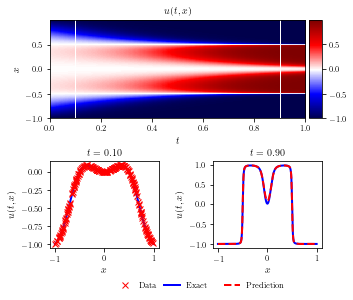

In [ ]:
# Plot solution
fig, ax = newfig(1.0, 1.2)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='nearest', cmap='seismic', 
              extent=[t.min(), t.max(), x_star.min(), x_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[idx_t0]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[idx_t1]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)


####### Row 1: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[idx_t0,:], 'b-', linewidth = 2) 
ax.plot(x0, u0, 'rx', linewidth = 2, label = 'Data')      
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize = 10)
ax.set_xlim([lb-0.1, ub+0.1])
ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)


ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[idx_t1,:], 'b-', linewidth = 2, label = 'Exact') 
ax.plot(x_star, U1_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')      
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)    
ax.set_xlim([lb-0.1, ub+0.1])

ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)

In [ ]:
# Save model
model.saver.save(model.sess, "../SavedModels/AllenCahn1D.ckpt")

'./SavedModels/AllenCahn1D.ckpt'